In [ ]:
#import packages
from nipype.interfaces.io import DataSink, SelectFiles, DataGrabber # Data i/o
from nipype.interfaces.utility import IdentityInterface, Function     # utility
from nipype.pipeline.engine import Node, Workflow, MapNode, JoinNode        # pypeline engine
from pandas import DataFrame, Series,read_csv

#set output file type for FSL to NIFTI_GZ
from nipype.interfaces.fsl.preprocess import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# MATLAB setup - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('~/spm12/toolbox')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

# Set study variables
#studyhome = '/Users/catcamacho/Box/SNAP/BABIES'
studyhome = '/home/camachocm2/Analysis/SNAP'
raw_data = studyhome + '/raw'
preproc_dir = studyhome + '/processed/preproc'
output_dir = studyhome + '/processed/network'
workflow_dir = studyhome + '/workflows'
subjects_info = read_csv(studyhome + '/misc/rest_subjects_info.csv',index_col=None, dtype={'subject_id':str})
subjects_info['subject_id'] = subjects_info['subject_id'].apply(lambda x: x.zfill(4))
subjects_list = subjects_info['subject_id'].tolist()

template_atlas = studyhome + '/rois/language_ROIs.nii.gz'
template_atlas_key = studyhome + '/rois/language_ROIs.csv'

proc_cores = 4 # number of cores of processing for the workflows

In [ ]:
def correlation_matrix(func,atlas,atlas_labels):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    from nilearn.input_data import NiftiLabelsMasker
    from nilearn.connectome import ConnectivityMeasure
    from nilearn import plotting
    from pandas import read_csv, DataFrame
    import matplotlib.pyplot as plt

    labels_df = read_csv(atlas_labels, index_col=None)
    labels = labels_df['region_name']
    masker = NiftiLabelsMasker(labels_img=atlas, standardize=True)
    time_series = masker.fit_transform(func)

    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    corr_mat_df = DataFrame(correlation_matrix,columns=labels,index=labels)
    corr_mat_df.to_csv('correlation_matrix.csv')

    plt.figure()
    plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                         vmax=0.8, vmin=-0.8, reorder=True)
    plt.savefig('corr_matrix.svg')
    plt.close()
    
    corr_mat_fig = abspath('corr_matrix.svg')
    corr_matrix = abspath('correlation_matrix.csv')
    
    return(corr_matrix, corr_mat_fig)

In [ ]:
## File handling Nodes

# Identity node- select subjects
infosource = Node(IdentityInterface(fields=['subject_id']),
                     name='infosource')
infosource.iterables = ('subject_id', subjects_list)

# Datasink- where our select outputs will go
substitutions = [('_subject_id_', '')]
datasink = Node(DataSink(), name='datasink')
datasink.inputs.base_directory = output_dir
datasink.inputs.container = output_dir
datasink.inputs.substitutions = substitutions

# Data grabber
file_template = {'func': preproc_dir + '/fully_processed_func/{subject_id}/fully_processed_func.nii.gz'}
selectfiles = Node(SelectFiles(file_template), name='selectfiles')

calc_connectivity = Node(Function(input_names=['func','atlas','atlas_labels'], 
                                  output_names=['corr_matrix','corr_mat_fig'], 
                                  function=correlation_matrix), 
                         name=calc_connectivity)
calc_connectivity.inputs.atlas = template_atlas
calc_connectivity.inputs.atlas_labels = template_atlas_key

In [ ]:
connect_flow = Workflow(name='connect_flow')
connect_flow.connect([(infosource,selectfiles, [('subject_id','subject_id')]),
                      (selectfiles, calc_connectivity, [('func','func')]),
                      
                      (calc_connectivity, datasink, [('corr_matrix','correlation_matrix'),
                                                     ('corr_mat_fig','corr_matrix_plot')])
                     ])

connect_flow.base_dir = workflow_dir
connect_flow.write_graph(graph2use='flat')
connect_flow.run('MultiProc', plugin_args={'n_procs': 10, 'memory_gb':30})

<Figure size 432x288 with 0 Axes>

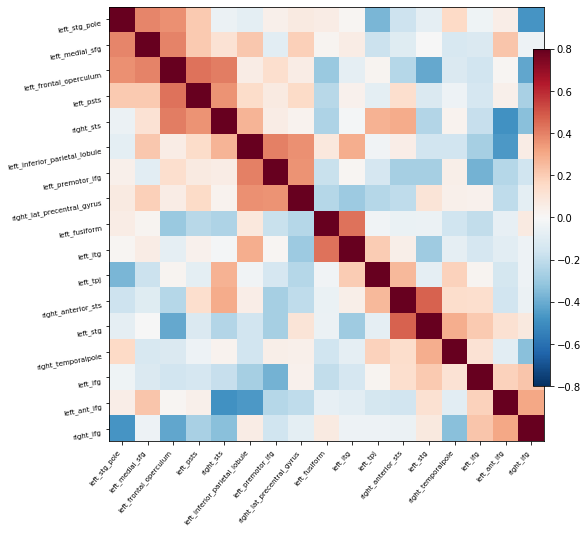

In [6]:
func='/home/camachocm2/Analysis/SNAP/processed/preproc/fully_processed_func/0045/_runnum_0/lomo_func.nii.gz'
atlas='/home/camachocm2/Analysis/SNAP/rois/language_ROIs.nii.gz'
atlas_labels='/home/camachocm2/Analysis/SNAP/rois/language_ROIs_key.csv'

from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from pandas import read_csv, DataFrame
import matplotlib.pyplot as plt

labels_df = read_csv(atlas_labels, index_col=None)
labels = labels_df['region_name']
masker = NiftiLabelsMasker(labels_img=atlas, standardize=True)
time_series = masker.fit_transform(func)

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
corr_mat_df = DataFrame(correlation_matrix,columns=labels,index=labels)
corr_mat_df.to_csv('correlation_matrix.csv')

plt.figure()
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True)
plt.savefig('corr_matrix.svg')
plt.show()
plt.close()

#corr_mat_fig = abspath('corr_matrix.svg')
#corr_matrix = abspath('correlation_matrix.csv')

In [ ]:
def graph_metrics(corr_matrix):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    
    
    
    return(graph_metrics)